# Missing Data Imputation Methods

Implementation of distribution-based imputation strategies for handling missing values in biological datasets.

# Distribution-Based Missing Data Imputation

What we do in this notebook:
1. Load the mass spec / proteomics toy dataset with missing values
2. Implement distribution-based imputation (percentile method)
3. Evaluate imputation quality with metrics (RMSE, MAE)
4. Perform parameter sensitivity analysis
5. Visualize imputation results

## Imports / setup
Import the libraries used below.

If something is not available in the virtual environment, install in the terminal:
```bash
pip install pandas numpy matplotlib scipy
```

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

# plotting style
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 120


## Config (paths and parameters)
All user-editable settings are collected here.

Definitions:
- `percentile_param`: lower quantile used to define the mean of the imputed values (e.g. 0.01 = 1% quantile / very low intensity).
- `ratio_param`: fraction of the original standard deviation used for imputed values (e.g. 0.30 = new std is 30% of the original std).

In [14]:
input_file_ms = "../data/ms_toy.txt"  # mass spec toy dataset with NAs

# default parameters for imputation
percentile_param = 0.01   # 1% lower tail
ratio_param      = 0.30   # 30% of the original std for imputed values

random_seed = 42          # reproducibility


## Load dataset and preview
Load `ms_toy.txt` (tab-separated, `NA` as missing).

Then:
- report shape,
- show the first rows,
- count how many `NA` values are in `ctrl.1`, which is the column used for imputation in this notebook.

In [15]:
ms_data = pd.read_csv(input_file_ms, sep="\t", header=0, na_values=["NA"])

print("data shape:", ms_data.shape)
display(ms_data.head())

# check missing values for ctrl.1
if "ctrl.1" in ms_data.columns:
    n_missing = ms_data["ctrl.1"].isna().sum()
    print(f"missing values in ctrl.1: {n_missing}")
else:
    print("warning: column 'ctrl.1' not found. please check column names.")


data shape: (6960, 6)


,ctrl.1,ctrl.2,ctrl.3,kout.1,kout.2,kout.3
0,25.495032,26.226134,25.696122,25.158000,25.801144,25.974257
1,32.432286,32.281099,32.305630,32.709666,32.657616,32.638734
2,31.099802,30.957954,31.130075,30.530179,30.719471,30.756368
3,NaN,23.817436,NaN,23.878580,23.808920,NaN
4,NaN,NaN,23.769814,24.153214,24.975744,24.086913


missing values in ctrl.1: 587


## Imputation function
Function `impute_low_expression` does the following for one column:

1. Take the non-missing values (`observed`).
2. Compute their mean and sample std (`overall_mean`, `overall_std`).
3. Compute a new mean for the missing values from the lower tail of a normal distribution with that mean/std.
   - Example: `percentile=0.01` means the 1% lower tail.
4. Compute a new std for the missing values: `new_std = ratio * overall_std`.
5. Sample random numbers from `Normal(new_mean, new_std)` for each missing entry.
6. Fill those sampled numbers back into the `NaN` positions.

The function returns:
- the imputed full column,
- only the values that were imputed (for plotting in red),
- a small dict with stats (for reporting).

In [16]:
def impute_low_expression(
    series,
    percentile=0.01,
    ratio=0.30,
    seed=42
):
    """
    series: pandas Series with numbers and NaN for missing
    percentile: lower tail percentile for the new mean (e.g. 0.01)
    ratio: fraction of original std for new std (e.g. 0.30)
    seed: random seed for reproducibility
    """

    rng = np.random.default_rng(seed)

    observed = series.dropna()

    overall_mean = observed.mean()
    overall_std  = observed.std(ddof=1)  # sample std like R default

    # new mean from lower quantile of normal(mean, std)
    new_mean = st.norm.ppf(percentile, loc=overall_mean, scale=overall_std)

    # new std as a fraction of original std
    new_std = overall_std * ratio

    # generate random values for each missing position
    na_mask = series.isna()
    n_missing = na_mask.sum()

    imputed_values = rng.normal(loc=new_mean, scale=new_std, size=n_missing)

    # build full imputed column
    full = series.copy()
    full.loc[na_mask] = imputed_values

    return full, imputed_values, {
        "overall_mean": overall_mean,
        "overall_std": overall_std,
        "new_mean": new_mean,
        "new_std": new_std,
        "n_missing": n_missing
    }


## Apply imputation on `ctrl.1` and plot histogram
Steps:
1. Run `impute_low_expression` on `ctrl.1` using the parameters from the config cell.
2. Overwrite `ctrl.1` in a copy of the dataframe with the imputed version.
3. Draw a histogram:
   - blue: all values after imputation,
   - red: only the imputed values.
4. Print the statistics (original mean/std, imputed mean/std, number of missing values).

imputation stats for ctrl.1:
  overall_mean: 29.036041174810997
  overall_std: 2.739044057746736
  new_mean: 22.66407185416768
  new_std: 0.8217132173240208
  n_missing: 587


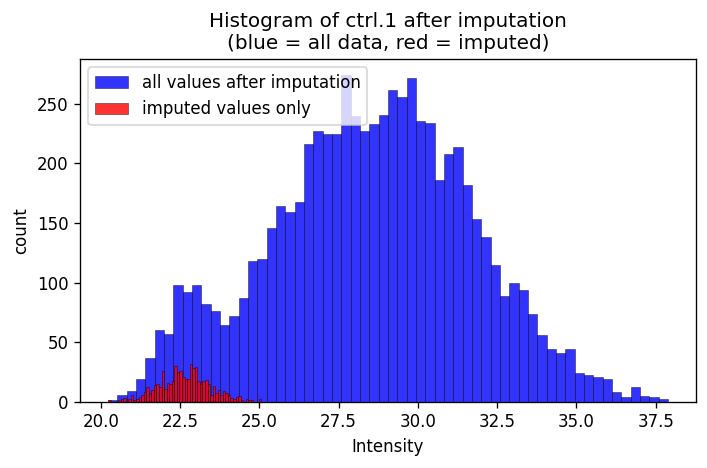


[metrics – distribution]
  method: distribution
  total_values_after: 6960
  n_imputed: 587
  imputed_fraction: 0.08433908045977012
  mean_after: 28.497105224927996
  std_after_sample: 3.174409417524323
  orig_mean: 29.036041174810997
  orig_std_sample: 2.739044057746736
  new_mean: 22.66407185416768
  new_std: 0.8217132173240208


In [17]:
# --- Distribution-based imputation for ctrl.1 WITH comparison-ready metrics ---

# run imputation for ctrl.1
ctrl1_full, ctrl1_imputed_only, stats_info = impute_low_expression(
    ms_data["ctrl.1"],
    percentile=percentile_param,
    ratio=ratio_param,
    seed=random_seed,
)

print("imputation stats for ctrl.1:")
for k, v in stats_info.items():
    print(f"  {k}: {v}")

# save back the imputed column
ms_data_imputed = ms_data.copy()
ms_data_imputed["ctrl.1"] = ctrl1_full


hist_bins = 60

# plot
plt.figure(figsize=(6,4))

# all values after imputation (blue)
plt.hist(
    ctrl1_full,
    bins=hist_bins,
    alpha=0.8,
    color="blue",
    edgecolor="black",
    linewidth=0.3,
    label="all values after imputation"
)

# imputed-only values (red), plotted on top
plt.hist(
    ctrl1_imputed_only,
    bins=hist_bins,
    alpha=0.8,
    color="red",
    edgecolor="black",
    linewidth=0.3,
    label="imputed values only"
)

plt.xlabel("Intensity")
plt.ylabel("count")
plt.title("Histogram of ctrl.1 after imputation\n(blue = all data, red = imputed)")
plt.legend()
plt.tight_layout()

# save fig
dist_plot_path = "ctrl1_imputation_hist.png"
plt.savefig(dist_plot_path, dpi=150, bbox_inches="tight")
plt.show()

# -------- comparison-ready metrics (distribution method) --------
obs = ms_data["ctrl.1"].dropna()

metrics_ctrl1_distribution = {
    "method": "distribution",
    "scope": "all_rows",
    "percentile_param": float(percentile_param),
    "ratio_param": float(ratio_param),
    "random_seed": int(random_seed),

    # original observed-only stats
    "orig_nonmissing_n": int(obs.shape[0]),
    "orig_mean": float(obs.mean()),
    "orig_std_sample": float(obs.std(ddof=1)),

    # distribution parameters that generated imputations
    "overall_mean": float(stats_info["overall_mean"]),
    "overall_std": float(stats_info["overall_std"]),
    "new_mean": float(stats_info["new_mean"]),
    "new_std": float(stats_info["new_std"]),
    "n_missing_original": int(stats_info["n_missing"]),

    # after-imputation (all rows)
    "total_values_after": int(ctrl1_full.shape[0]),
    "n_imputed": int(len(ctrl1_imputed_only)),
    "imputed_fraction": float(len(ctrl1_imputed_only) / ctrl1_full.shape[0]),
    "mean_after": float(ctrl1_full.mean()),
    "std_after_sample": float(ctrl1_full.std(ddof=1)),
    "min_after": float(np.min(ctrl1_full)),
    "max_after": float(np.max(ctrl1_full)),
    "p25_after": float(np.percentile(ctrl1_full, 25)),
    "p50_after": float(np.percentile(ctrl1_full, 50)),
    "p75_after": float(np.percentile(ctrl1_full, 75)),

    # outputs
    "histogram_path": dist_plot_path,
}

# print a compact preview
print("\n[metrics – distribution]")
for k in [
    "method","total_values_after","n_imputed","imputed_fraction",
    "mean_after","std_after_sample","orig_mean","orig_std_sample",
    "new_mean","new_std"
]:
    print(f"  {k}: {metrics_ctrl1_distribution[k]}")

# persist per-method metrics
pd.DataFrame([metrics_ctrl1_distribution]).to_csv(
    "ctrl1_metrics_distribution.csv", index=False
)


metrics_list = [metrics_ctrl1_distribution]

# if a kNN metrics dict already exists in the list, also write a combined summary
if any(m.get("method") == "knn" for m in metrics_list):
    pd.DataFrame(metrics_list).to_csv("ctrl1_metrics_summary.csv", index=False)
    print("\nSaved combined summary: ctrl1_metrics_summary.csv")


## Parameter Sensitivity Analysis

Exploring the impact of different parameters on imputation quality:
- What happens if the percentile threshold changes?
- How does the choice of distribution affect results?


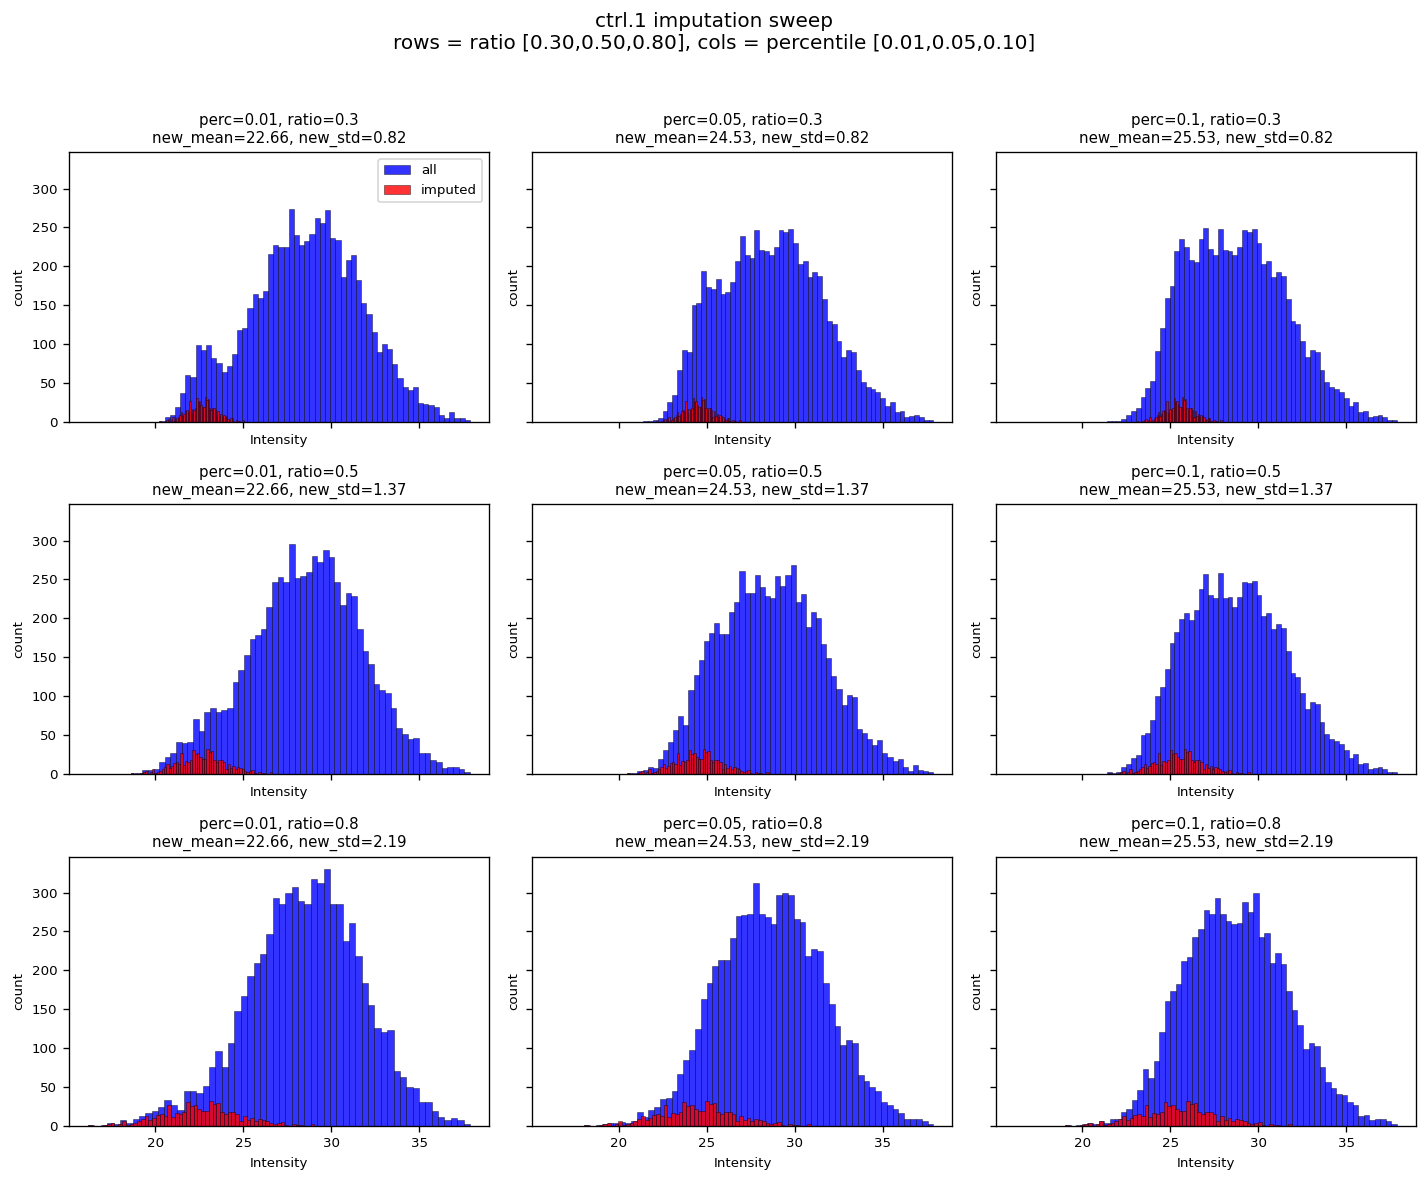

summary of runs:
percentile=0.01, ratio=0.3 | new_mean=22.664, new_std=0.822, overall_mean=29.036, overall_std=2.739, n_missing=587
percentile=0.05, ratio=0.3 | new_mean=24.531, new_std=0.822, overall_mean=29.036, overall_std=2.739, n_missing=587
percentile=0.1, ratio=0.3 | new_mean=25.526, new_std=0.822, overall_mean=29.036, overall_std=2.739, n_missing=587
percentile=0.01, ratio=0.5 | new_mean=22.664, new_std=1.370, overall_mean=29.036, overall_std=2.739, n_missing=587
percentile=0.05, ratio=0.5 | new_mean=24.531, new_std=1.370, overall_mean=29.036, overall_std=2.739, n_missing=587
percentile=0.1, ratio=0.5 | new_mean=25.526, new_std=1.370, overall_mean=29.036, overall_std=2.739, n_missing=587
percentile=0.01, ratio=0.8 | new_mean=22.664, new_std=2.191, overall_mean=29.036, overall_std=2.739, n_missing=587
percentile=0.05, ratio=0.8 | new_mean=24.531, new_std=2.191, overall_mean=29.036, overall_std=2.739, n_missing=587
percentile=0.1, ratio=0.8 | new_mean=25.526, new_std=2.191, overa

In [18]:
# grid sweep over percentile (columns) and ratio (rows)

percentile_list = [0.01, 0.05, 0.10]   # low, medium, high percentile
ratio_list      = [0.30, 0.50, 0.80]   # low, medium, high ratio

results_stats = []  # store stats from each run

fig, axes = plt.subplots(
    nrows=len(ratio_list),
    ncols=len(percentile_list),
    figsize=(12, 10),
    sharex=True,
    sharey=True
)

for r_i, ratio_val in enumerate(ratio_list):
    for p_i, perc_val in enumerate(percentile_list):

        # run imputation for this combo
        full_col, imputed_only, stats_cur = impute_low_expression(
            ms_data["ctrl.1"],
            percentile=perc_val,
            ratio=ratio_val,
            seed=random_seed,
        )

        # save stats
        results_stats.append({
            "percentile": perc_val,
            "ratio": ratio_val,
            "overall_mean": stats_cur["overall_mean"],
            "overall_std": stats_cur["overall_std"],
            "new_mean": stats_cur["new_mean"],
            "new_std": stats_cur["new_std"],
            "n_missing": stats_cur["n_missing"]
        })

        ax = axes[r_i, p_i]

        # plot blue = all values after imputation
        ax.hist(
            full_col,
            bins=60,
            alpha=0.8,
            color="blue",
            edgecolor="black",
            linewidth=0.3,
            label="all"
        )

        # plot red = only imputed values
        ax.hist(
            imputed_only,
            bins=60,
            alpha=0.8,
            color="red",
            edgecolor="black",
            linewidth=0.3,
            label="imputed"
        )

        # title for this subplot
        ax.set_title(
            f"perc={perc_val}, ratio={ratio_val}\nnew_mean={stats_cur['new_mean']:.2f}, new_std={stats_cur['new_std']:.2f}",
            fontsize=9
        )
        ax.set_xlabel("Intensity", fontsize=8)
        ax.set_ylabel("count", fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

# only add one legend for the whole figure (top-left subplot)
axes[0,0].legend(fontsize=8)

plt.suptitle(
    "ctrl.1 imputation sweep\nrows = ratio [0.30,0.50,0.80], cols = percentile [0.01,0.05,0.10]",
    fontsize=12
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# print numeric summary
print("summary of runs:")
for row in results_stats:
    print(
        f"percentile={row['percentile']}, ratio={row['ratio']} | "
        f"new_mean={row['new_mean']:.3f}, new_std={row['new_std']:.3f}, "
        f"overall_mean={row['overall_mean']:.3f}, overall_std={row['overall_std']:.3f}, "
        f"n_missing={row['n_missing']}"
    )

# save figure
fig.savefig("ctrl1_imputation_sweep.png", dpi=150, bbox_inches="tight")


# Results and Discussion

### Analysis of Imputation Methods

Discussion of distribution-based imputation performance and parameter sensitivity.
